In [1]:
import math, matplotlib.pyplot as plt, torch
from torch import tensor

In [2]:
n_clusters = 6
n_samples = 250 * 10

In [3]:
centroids = torch.rand(n_clusters,2)*70-35
centroids.shape, centroids.min(), centroids.max()

(torch.Size([6, 2]), tensor(-29.4100), tensor(33.4799))

In [4]:
from torch.distributions.multivariate_normal import MultivariateNormal

In [5]:
def sample(m):
    return MultivariateNormal(m, torch.diag(tensor([5., 5.]))).sample((n_samples,))

In [6]:
slices = [sample(c) for c in centroids]
data = torch.cat(slices)
data.shape

torch.Size([15000, 2])

In [7]:
def plot_data(centroids, data):
    _,ax = plt.subplots()
    for i,centroid in enumerate(centroids):
        samples = data[i*n_samples:(i+1)*n_samples]
        ax.scatter(samples[:,0], samples[:,1], s=1)
        ax.plot(*centroid, markersize=10, marker='x', color='k', mew=5)
        ax.plot(*centroid, markersize=5, marker='x', color='m', mew=3)
        

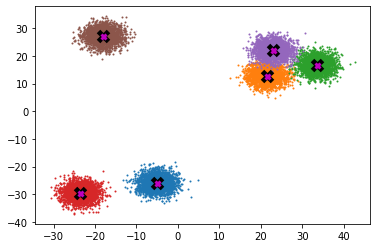

In [8]:
plot_data(centroids, data)

In [9]:
midp = data.mean(0)
midp

tensor([5.1857, 3.9647])

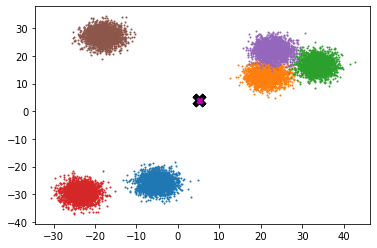

In [10]:
plot_data([midp]*n_clusters, data)

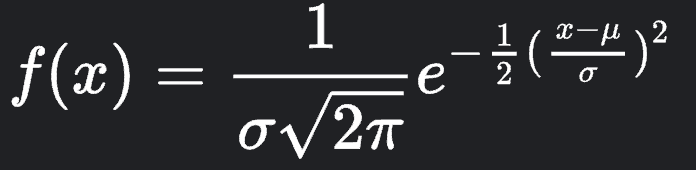

In [11]:
def gaussian(d, bw): return torch.exp(-0.5*((d/bw))**2) / (bw*math.sqrt(2*math.pi))

In [12]:
def plot_func(f):
    x = torch.linspace(0, 10, 100)
    plt.plot(x, f(x))
    

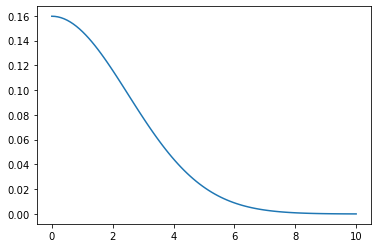

In [13]:
from functools import partial

plot_func(partial(gaussian, bw=2.5))

In [14]:
def tri(d, i):
    return (-d+i).clamp_min(0)/i

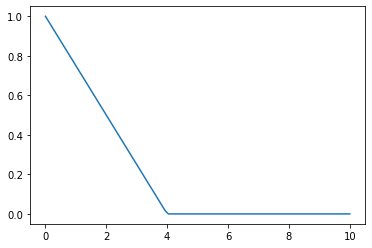

In [15]:
plot_func(partial(tri, i=4))

In [16]:
def one_update(X):
    for i,x in enumerate(X):
        dist = ((x-X)**2).sum(1).sqrt()
        weights = gaussian(dist, 2.5)
#         weights = tri(dist, 8)
        X[i] = (weights[:,None]*X).sum(0)/weights.sum()

In [17]:
def mean_shift(data):
    X = data.clone()
    for i in range(5):
        one_update(X)
    return X

In [18]:
# %time X = mean_shift(data)

In [19]:
# plot_data(centroids+2, X)

In [20]:
# plot_data(centroids+2, data)

In [21]:
def pick_clusters(data, min_dist=2):
    X = data.clone()
    clusters = []
    for i in range(X.shape[0]):
        x = X[i]
        if (x.abs()>0).float().sum().item() > 0:
            clusters.append(x)
            dist = ((x-X)**2).sum(1).sqrt()
            nearby = (dist>=min_dist).float()
            X = X*nearby[:,None]
    return torch.stack(clusters)

In [22]:
# %time X = mean_shift(data)

In [23]:
# %time pred_centroids = pick_clusters(X, min_dist=1)

In [24]:
# plot_data(pred_centroids, data)
# pred_centroids.shape

In [25]:
# plot_data(centroids, data)
# centroids.shape

In [26]:
def mean_shift2(data, tolerance=0.1):
    X = data.clone()
    XPrev = torch.zeros_like(X)
    while ((X-XPrev).abs().sum(0).sum() >= 2*tolerance):
        XPrev = X.clone()
        one_update(X)
    return X

In [27]:
# %time X = mean_shift2(data)

In [28]:
# plot_data(centroids+5, X)

In [29]:
h = 2.5
X = data.clone()
c,s = {},{}
for i, x in enumerate(X):
    idx = tuple((x/h).floor().tolist())
    c[idx] = c.get(idx, 0) + 1
    if idx not in s:
        s[idx] = torch.zeros_like(x)
    s[idx] += x

In [30]:
from itertools import product

def one_update_plus_plus(X, h=2.5):
    nearyby_points = list(product([-1, 0, 1], repeat=2))
    c,s = {},{}
    for i, x in enumerate(X):
        idx = tuple((x/h).floor().tolist())
        c[idx] = c.get(idx, 0) + 1
        if idx not in s:
            s[idx] = torch.zeros_like(x)
        s[idx] += x
    
    for i,x in enumerate(X):
        idx = tuple((x/h).floor().tolist())
        sums = torch.zeros_like(x)
        counts = 0
        for p in nearyby_points:
            p = tuple((tensor(idx) + tensor(p)).tolist())
            if p in s:
                sums += s[p]
                counts += c[p]
        X[i] = sums/counts

In [31]:
def mean_shift_plus_plus(data, h):
    X = data.clone()
    for i in range(5):
        one_update_plus_plus(X, h)
    return X

In [32]:
%time X = mean_shift_plus_plus(data, h=3.5)

CPU times: user 11.4 s, sys: 57.1 ms, total: 11.5 s
Wall time: 11.6 s


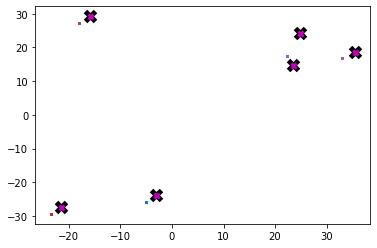

In [33]:
plot_data(centroids+2, X)

In [34]:
%time X = mean_shift(data)

CPU times: user 3min 41s, sys: 1min 2s, total: 4min 43s
Wall time: 59.7 s


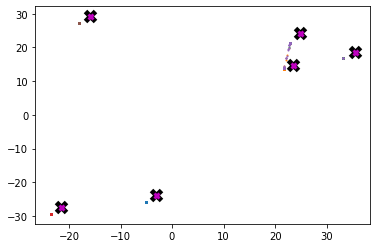

In [35]:
plot_data(centroids+2, X)

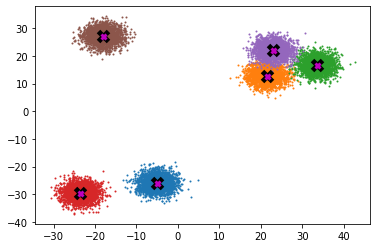

In [36]:
plot_data(centroids, data)